In [35]:
#import required packages
import pickle
import numpy as np
import pandas as pd
import re
import time, sys
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.corpus import stopwords
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from tqdm import tqdm
from IPython.display import clear_output
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from time import time

In [36]:
#initiate all the functions
stopnltk = set(stopwords.words('indonesian'))
factory = StopWordRemoverFactory()
stopsastrawi = factory.get_stop_words()
stemfactory = StemmerFactory()
stemmer = stemfactory.create_stemmer()
tf = TfidfVectorizer()
mnb = MultinomialNB() #multinomial naive bayes classifier
mlp = MLPClassifier(alpha=1, max_iter=2000) #MLP classifier
clf = svm.SVC(gamma='scale') #SVM classifier
smt = SMOTE()
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')

In [4]:
#open pickle files 'train.pkl' and 'test.pkl', and then assign the result to train and test respectively
with open('train.pkl', 'rb') as a:
    train = pickle.load(a)
    
with open('test.pkl', 'rb') as b:
    test = pickle.load(b)

In [5]:
#create new feature called word_count to see how many words that each document has within train set
train['word_count'] = train['RESPONSE'].apply(lambda x: len(str(x).split()))

In [6]:
#check basic statistic of train set
train.describe()

,LABEL,word_count
count,3392.000000,3392.000000
mean,0.074882,18.858196
std,0.263240,7.294067
min,0.000000,1.000000
25%,0.000000,14.000000
50%,0.000000,19.000000
75%,0.000000,24.000000
max,1.000000,174.000000


In [7]:
#as we can see on the prev. cell that the max words is at 174 words while the average words within train is 19 words.
#we can consider this as outlier. First, take a look at how many docs have words more that 100
train[train['word_count'] > 100]

,RESPONSE,LABEL,word_count
199,alia sedang mengerjakan sebuah laporan tentang...,0,174


In [8]:
#after we found it, then remove 'em all
train = train.drop(index=199)

In [9]:
#word processing

target = []
alphanum = re.compile(r"[^a-zA-Z ]")

train['RESPONSE'] = train['RESPONSE'].astype('str')
for i in train['RESPONSE']:
    i = i.lower() #unification
    i = re.sub(alphanum, ' ', i) #remove non alpha-num chars
    i = re.sub('[\s]+', ' ', i) #remove additional whitespaces
    target.append(i)
    
train['RESPONSE'] = target

In [11]:
#stopwords removal. We use NLTK instead of Sastrawi because NLTK has more words than Sastrawi.

target = []
for i in train['RESPONSE']:
    filtered_sentence = [w for w in i.split() if not w in stopnltk]
    i = ' '.join(filtered_sentence)
    target.append(i)
    
train['RESPONSE'] = target

In [12]:
#create new feature called word_count_wo_stopword to see how many words that each document has within train set,
#after stop word removal.
train['word_count_wo_stopword'] = train['RESPONSE'].apply(lambda x: len(str(x).split()))

In [13]:
train.describe()

,LABEL,word_count,word_count_wo_stopword
count,3391.000000,3391.000000,3391.000000
mean,0.074904,18.812445,13.885579
std,0.263275,6.790952,5.546415
min,0.000000,1.000000,0.000000
25%,0.000000,14.000000,10.000000
50%,0.000000,19.000000,14.000000
75%,0.000000,24.000000,18.000000
max,1.000000,89.000000,49.000000


In [14]:
#remove observations that have words less than 3.
drop = train[train['word_count_wo_stopword'] < 3]
dr = []
for i in drop.iterrows():
    dr.append(i[0])
    
train = train.drop(index=dr)

In [15]:
train.describe()

,LABEL,word_count,word_count_wo_stopword
count,3325.000000,3325.000000,3325.000000
mean,0.066767,19.090827,14.132331
std,0.249655,6.550566,5.313736
min,0.000000,3.000000,3.000000
25%,0.000000,14.000000,10.000000
50%,0.000000,19.000000,14.000000
75%,0.000000,24.000000,18.000000
max,1.000000,89.000000,49.000000


In [16]:
#stemming

target = []
t0 = time()
for i in train['RESPONSE']:
    i = stemmer.stem(i)
    target.append(i)

process_time = time() - t0
print("Process time: %0.3fs" % process_time)
train['RESPONSE'] = target

Process time: 32.232s


In [17]:
#split the data into 2 sets. train, and test.
response_tr, response_te, label_tr, label_te = train_test_split(train.RESPONSE, train.LABEL, stratify=train.LABEL, test_size=0.33)
print("Training: ",response_tr.shape)
print("Testing: ",response_te.shape)

Training:  (2227,)
Testing:  (1098,)


In [18]:
#vectorizer the documents using tf-idf
Xtr = tf.fit_transform(response_tr)
Xte = tf.transform(response_te)

In [19]:
print(Xtr.shape)
print(Xte.shape)

(2227, 531)
(1098, 531)


In [22]:
#fit and predict using MNB classifier.
mnb.fit(Xtr, label_tr)
pred = mnb.predict(Xte)
print(classification_report(label_te, pred, target_names=None))

              precision    recall  f1-score   support

           0       0.93      1.00      0.97      1025
           1       0.00      0.00      0.00        73

    accuracy                           0.93      1098
   macro avg       0.47      0.50      0.48      1098
weighted avg       0.87      0.93      0.90      1098



/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


As we can see, the accuracy is good but precision, recall, and f1-score for class 1 is not good. This is because the imbalance dataset that we have. Let's see the next classifier

In [23]:
#fit and predict using SVM classifier.
clf.fit(Xtr, label_tr)
predSVM = clf.predict(Xte)
print(classification_report(label_te, predSVM, target_names=None))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1025
           1       0.87      0.45      0.59        73

    accuracy                           0.96      1098
   macro avg       0.92      0.72      0.79      1098
weighted avg       0.96      0.96      0.95      1098



SVM shows better accuracy, better precision, but still low in term of recall score. This means the model can’t detect the class well but is highly trustable when it does. We won't let it happen. Let's see next classifier

In [24]:
#fit and predict using MLP classifier.
mlp.fit(Xtr, label_tr)
predMLP = mlp.predict(Xte)
print(classification_report(label_te, predMLP, target_names=None))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1025
           1       1.00      0.05      0.10        73

    accuracy                           0.94      1098
   macro avg       0.97      0.53      0.54      1098
weighted avg       0.94      0.94      0.91      1098



MLP shows the same accuracy as SVM does. However, precision for class 1 is increased slightly. Again, this is because an imbalance dataset. Let's see the distribution of our train set label

In [26]:
train.LABEL.value_counts()

0    3103
1     222
Name: LABEL, dtype: int64

It's clearly see that the distribution between class 1 and 0 is imbalance. This is why the model get high accuracy but low on recall for class 1. 

We can deal with imbalance data set with SMOTE (Synthetic Minority Over-sampling Technique)

In [27]:
#resampling dataset to deal with imbalance class

X_train, y_train = smt.fit_sample(Xtr, label_tr)
X_test, y_test = smt.fit_sample(Xte, label_te)

In [28]:
np.bincount(y_train)

array([2078, 2078])

Now we have the same size of class 1 and 0. Let's then try to feed the new balance data to the classifiers

In [29]:
#fit and predict using MNB classifier with balance dataset
mnb.fit(X_train, y_train)
predMNBSmote = mnb.predict(X_test)
print(classification_report(y_test, predMNBSmote, target_names=None))

              precision    recall  f1-score   support

           0       0.85      0.97      0.90      1025
           1       0.96      0.82      0.89      1025

    accuracy                           0.90      2050
   macro avg       0.90      0.90      0.89      2050
weighted avg       0.90      0.90      0.89      2050



comparing with the previous result of MNB, this accuracy is below the previous one. But the precision, recall, and f1-score show that the data is handled well by the model. Let's try for SVM.

In [30]:
#fit and predict using SVM classifier with balance dataset
clf.fit(X_train, y_train)
predSVMSMOTE = clf.predict(X_test)
print(classification_report(y_test, predSVMSMOTE, target_names=None))

              precision    recall  f1-score   support

           0       0.84      0.99      0.91      1025
           1       0.99      0.81      0.89      1025

    accuracy                           0.90      2050
   macro avg       0.91      0.90      0.90      2050
weighted avg       0.91      0.90      0.90      2050



SVM with balanced dataset shows better performance that MNB above. Let's see the last one. MLP

In [31]:
#fit and predict using MLP classifier with balance dataset
mlp.fit(X_train, y_train)
predMLPSMOTE = mlp.predict(X_test)
print(classification_report(y_test, predMLPSMOTE, target_names=None))

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1025
           1       0.95      0.87      0.91      1025

    accuracy                           0.91      2050
   macro avg       0.92      0.91      0.91      2050
weighted avg       0.92      0.91      0.91      2050



array([[979,  46],
       [132, 893]])

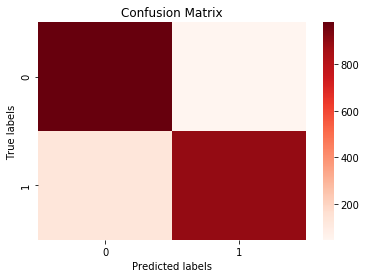

In [33]:
#confussion matrix of the model that has highest accuracy
labels = ['0', '1']
cm = confusion_matrix(y_test, predMLPSMOTE)
ax= plt.subplot()
sns.heatmap(cm, cmap='Reds', ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix') 

cm

Our baseline is 90%, so accuracy 91 is just too close with base line. I try to adjust things, and that is to change the vectorizer. Above methods are used tf-idf as word vectorizer. Try change it to bag of word and let's see the result.

In [37]:
#vectorizer the documents using bag of word
Xtr = count_vect.fit_transform(response_tr)
Xte = count_vect.transform(response_te)

In [38]:
print(Xtr.shape)
print(Xte.shape)

(2227, 533)
(1098, 533)


In [39]:
#for the sake of simplicity, we are going to jump directly to SMOTE
#resampling dataset to deal with imbalance class

X_train, y_train = smt.fit_sample(Xtr, label_tr)
X_test, y_test = smt.fit_sample(Xte, label_te)

In [40]:
#fit and predict using MNB classifier with balance dataset and bag of words
mnb.fit(X_train, y_train)
predMNBSmote = mnb.predict(X_test)
print(classification_report(y_test, predMNBSmote, target_names=None))

              precision    recall  f1-score   support

           0       0.89      0.98      0.93      1025
           1       0.98      0.87      0.92      1025

    accuracy                           0.93      2050
   macro avg       0.93      0.93      0.93      2050
weighted avg       0.93      0.93      0.93      2050



At first run, we get higher measurement among all the classifiers with tf-idf. Let's see for SVM

In [44]:
#fit and predict using SVM classifier with balance dataset and bag of words
clf.fit(X_train, y_train)
predSVMSMOTE = clf.predict(X_test)
print(classification_report(y_test, predSVMSMOTE, target_names=None))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1025
           1       0.98      0.96      0.97      1025

    accuracy                           0.97      2050
   macro avg       0.97      0.97      0.97      2050
weighted avg       0.97      0.97      0.97      2050



SVM outperform MNB

In [45]:
#fit and predict using MLP classifier with balance dataset and bag of words
mlp.fit(X_train, y_train)
predMLPSMOTE = mlp.predict(X_test)
print(classification_report(y_test, predMLPSMOTE, target_names=None))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97      1025
           1       0.96      0.98      0.97      1025

    accuracy                           0.97      2050
   macro avg       0.97      0.97      0.97      2050
weighted avg       0.97      0.97      0.97      2050



Because SVM and MLP have the same score, we are going to use them to predict label from test set.

In [51]:
#test model using test set
Xtarget = count_vect.transform(test.RESPONSE)

resultSVM = clf.predict(Xtarget)

resultMLP = mlp.predict(Xtarget)

In [52]:
test['LABEL_SVM'] = resultSVM
test['LABEL_MLP'] = resultMLP

In [54]:
test.to_csv('TEST_WITH_LABEL.CSV')